![tuning](https://user-images.githubusercontent.com/54896849/116710403-5992c180-a9ef-11eb-969c-c06841f7b09b.PNG)

#### Tuning techniques:
1. Manual Search
2. Random Search
3. Grid Search
4. Automated Hyperparameter Tuning (Bayesian Optimization, Genetic Algorithms)

# Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

C:\Users\Amit\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


# Data Preparation

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Null-value removal

In [3]:
df.isnull().sum() * 100 / len(df)

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

### Down-scaling

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
df2 = df[df.Class == 1][0:492]
df3 = df[df.Class == 0][0:492]
df = df2.append(df3, ignore_index=True)
df.shape

(984, 31)

### Feature Selection

<AxesSubplot:>

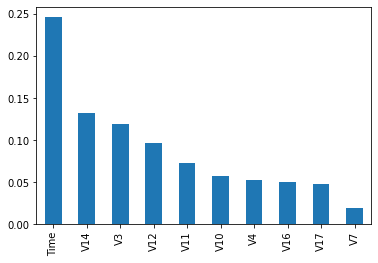

In [6]:
# define data
X = df.drop(['Class'], axis = 1).values
Y = df['Class']
X = StandardScaler().fit_transform(X)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

# define model
model = RandomForestClassifier()

# train model
model.fit(X_Train,Y_Train)

# Feature importance score
feat_importances = pd.Series(model.feature_importances_, index=df.drop(df[['Class']], 
                                                                       axis=1).columns)
feat_importances.nlargest(10).plot.bar()

### Train-test split

In [7]:
X = df[list(feat_importances.nlargest(6).index)[1:]]
Y = df['Class']
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

# Base Model (without Hyperparameter Tuning)

In this tutorial, I'll take Random Forest as my base model since it has a lot of hyperparameters.

The main parameters used by a Random Forest Classifier are:
- criterion = the function used to evaluate the quality of a split.
- max_depth = maximum number of levels allowed in each tree.
- max_features = maximum number of features considered when splitting a node.
- min_samples_leaf = minimum number of samples which can be stored in a tree leaf.
- min_samples_split = minimum number of samples necessary in a node to cause node splitting.
- n_estimators = number of trees in the ensamble.

In [8]:
# training
model = RandomForestClassifier(random_state= 101)
model.fit(X_Train,Y_Train)

RandomForestClassifier(random_state=101)

In [9]:
# testing
predictionforest = model.predict(X_Test)
acc1 = accuracy_score(Y_Test,predictionforest)
acc1

0.9358108108108109

# Models (with Hyperparameter Tuning)

## Manual Search

When using Manual Search, we choose some model hyperparameters based on our judgment/experience. We then train the model, evaluate its accuracy and start the process again. This loop is repeated until a satisficatory accuracy is achieved.

In [10]:
# training
model = RandomForestClassifier(n_estimators= 200, max_features = "log2", min_samples_leaf = 20, random_state= 101)
model.fit(X_Train,Y_Train)

RandomForestClassifier(max_features='log2', min_samples_leaf=20,
                       n_estimators=200, random_state=101)

In [11]:
# testing
predictionforest = model.predict(X_Test)
acc2 = accuracy_score(Y_Test,predictionforest)
acc2

0.9324324324324325

## Random Search

In Random Search, we create a grid of hyperparameters and train/test our model on just some random combination of these hyperparameters.

In [12]:
# Domain/Search Space
random_search = {
               'criterion': ['entropy', 'gini'],
               'max_depth': list(range(10,2100,100)) + [None],
               'max_features': ['auto','sqrt','log2',None],
               'min_samples_leaf': [1,2,4,6,8],
               'min_samples_split': list(range(2,20,2)),
               'n_estimators': list(range(100,2100,100))
                }

In [13]:
# training
clf = RandomForestClassifier()

model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 4, verbose= 0, random_state= 101, n_jobs = -1)

model.fit(X_Train,Y_Train)

model.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 6,
 'max_features': 'log2',
 'max_depth': 1810,
 'criterion': 'entropy'}

In [14]:
# testing
predictionforest = model.best_estimator_.predict(X_Test)
acc3 = accuracy_score(Y_Test,predictionforest)
acc3

0.9358108108108109

## Grid Search

In Grid Search, we set up a grid of hyperparameters and train/test our model on each of the possible combinations. 


In order to choose the parameters to use in Grid Search, we can try to run first Random Search to get an understanding of which values might perform best on the considered dataset.

In [16]:
# Domain/Search Space
grid_search = {
    'criterion': [model.best_params_['criterion']],
    'max_depth': [model.best_params_['max_depth']],
    'max_features': [model.best_params_['max_features']],
    'min_samples_leaf': [model.best_params_['min_samples_leaf'] - 2, 
                         model.best_params_['min_samples_leaf'], 
                         model.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [model.best_params_['min_samples_split'] - 3, 
                          model.best_params_['min_samples_split'], 
                          model.best_params_['min_samples_split'] + 3],
    'n_estimators': [model.best_params_['n_estimators'] - 150, model.best_params_['n_estimators'] - 100, 
                     model.best_params_['n_estimators'], 
                     model.best_params_['n_estimators'] + 100, model.best_params_['n_estimators'] + 150]
}

In [17]:
# training
clf = RandomForestClassifier()

model = GridSearchCV(estimator = clf, param_grid = grid_search, cv = 4, verbose= 0, n_jobs = -1)

model.fit(X_Train,Y_Train)

model.best_params_

{'criterion': 'entropy',
 'max_depth': 1810,
 'max_features': 'log2',
 'min_samples_leaf': 6,
 'min_samples_split': 13,
 'n_estimators': 1600}

In [18]:
# testing
predictionforest = model.best_estimator_.predict(X_Test)
acc4 = accuracy_score(Y_Test,predictionforest)
acc4

0.9425675675675675

* Grid Search is slower compared to Random Search but can be more effective because it can go through the whole search space. 
* Random Search is faster , but might miss some important points in the search space.

## Automated Hyperparameter Tuning

### Bayesian Optimization

* Bayesian optimization uses probability to find the minimum of a function. 
* The final aim is to find the input value to a function which can gives us the lowest possible output value. 

* Instead of using random combinations of values for the hyperparameters, it looks at the current results obtained and predict regions of the hyperparameter space that might give better results.

* Baysian optimization has been proved to be more efficient than random, grid or manual search. 
* Bayesian Optimization can therefore lead to better performance in the testing phase and reduced optimization time.

* Hyperopt is a Python library used to optimize Machine Learning models using Bayesian Optimization. 
* In Hyperopt, Bayesian Optimization can be implemented by giving 3 three main parameters to the function fmin.
    1. Objective Function = defines the loss function to minimize.
    2. Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
    3. Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration. 

In [19]:
# Objective Function
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_Train, Y_Train, cv = 4).mean()
    
    return {'loss': -accuracy, 'status': STATUS_OK }

In [41]:
# Domain Space
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.choice('max_depth', list(range(10,2100,100)) + [None]),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.choice ('min_samples_leaf', [2,4,6,8]),
        'min_samples_split' : hp.choice ('min_samples_split', list(range(2,20,2))),
        'n_estimators' : hp.choice('n_estimators', list(range(100,2100,100)))
    }

In [42]:
# Optimization Algorithm = tpe.suggest

trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials)
best

100%|████████████████████████████████████████████████| 100/100 [09:14<00:00,  5.54s/it, best loss: -0.9476744186046512]


{'criterion': 0,
 'max_depth': 10,
 'max_features': 0,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 11}

In [45]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {11: 1200}

print(crit[best['criterion']],feat[best['max_features']],est[best['n_estimators']])

entropy auto 1200


In [46]:
# training
model = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']])
model.fit(X_Train,Y_Train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=7, n_estimators=1200)

In [47]:
# testing
predictionforest = model.predict(X_Test)
acc5 = accuracy_score(Y_Test,predictionforest)
acc5

0.9391891891891891

### Genetic Algorithm

* Sub-class of Evolutionary Algorithms. Natural evolution in biological populations.
* Child/off-spring inherits the best characteristics of parents.
* Genetic Algorithms tries to apply this natural selection mechanisms to Machine Learning contexts.

#### Steps:
1. Create a population of N Machine Learning models with some predifined Hyperparameters. 
2. Selection- Calculate the accuracy of each model and decide to keep just half of the models (the ones that performs best; highest fitness). 
3. Reproduction- Generate N offsprings having similar Hyperparameters to the ones of the best models.
4. Repeat steps 2 and 3 for a defined number of generations (convergence).

In this way, just the best models will survive at the end of the process.

In [48]:
# Domain/Search Space
parameters = {
               'criterion': ['entropy', 'gini'],
               'max_depth': list(range(10,2100,100)) + [None],
               'max_features': ['auto','sqrt','log2',None],
               'min_samples_leaf': [1,2,4,6,8],
               'min_samples_split': list(range(2,20,2)),
               'n_estimators': list(range(100,2100,100))
                }

In [53]:
# training
model = TPOTClassifier(generations= 5, 
                       population_size= 50,
                       verbosity= 2, 
                       early_stop= 12,
                       config_dict={'sklearn.ensemble.RandomForestClassifier': parameters}, 
                       cv = 4, 
                       scoring = 'accuracy')
model.fit(X_Train,Y_Train)

Version 0.11.6 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9491279069767442

Generation 2 - Current best internal CV score: 0.9491279069767442

Generation 3 - Current best internal CV score: 0.9491279069767442

Generation 4 - Current best internal CV score: 0.9491279069767442

Generation 5 - Current best internal CV score: 0.9491279069767442

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=entropy, max_depth=1310, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=400)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [10,
                                                                                      110,
                                                                                      210,
                                                                                      310,
                                                                                      410,
                                                                                      510,
                                                                                      610,
                                                                                      710,
                                                                                 

In [54]:
# testing
predictionforest = model.predict(X_Test)
acc6 = accuracy_score(Y_Test,predictionforest)
acc6

0.9391891891891891

# Performace Comparison

In [60]:
print('Base Model vs Manual Search Accuracy {:0.4f}%.'.format( 100 * (acc2 - acc1) / acc1))
print('Base Model vs Random Search Accuracy {:0.4f}%.'.format( 100 * (acc3 - acc1) / acc1))
print('Base Model vs Grid Search Accuracy {:0.4f}%.'.format( 100 * (acc4 - acc1) / acc1))
print('Base Model vs Hyperopt Accuracy {:0.4f}%.'.format( 100 * (acc5 - acc1) / acc1))
print('Base Model vs TPOT Accuracy {:0.4f}%.'.format( 100 * (acc6 - acc1) / acc1))

Base Model vs Manual Search Accuracy -0.3610%.
Base Model vs Random Search Accuracy 0.0000%.
Base Model vs Grid Search Accuracy 0.7220%.
Base Model vs Hyperopt Accuracy 0.3610%.
Base Model vs TPOT Accuracy 0.3610%.
